## Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
import math
import folium

plt.style.use("seaborn-dark")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data ingestion

We read all gifts into a holding variable; we will use various slices of this in later work

In [3]:
DATA_DIR = "Data\\" # Directory for Raw data of gifts locations and weight.
IMAGE_DIR = "Images\\" # Stores all the graphs/images of results generated.

# get all gifts into a global variable so that we can decorate the selected points and show path
# read in the gifts data
all_gifts = pd.read_csv(DATA_DIR + "gifts.csv")

# Review first five rows (First row is the coordinates of Lapland)
all_gifts.head()

,GiftId,Latitude,Longitude,Weight
0,0,52.900000,26.500000,0.000000
1,1,16.345769,6.303545,1.000000
2,2,12.494749,28.626396,15.524480
3,3,27.794615,60.032495,8.058499
4,4,44.426992,110.114216,1.000000


## World Map Generation (Define the domain)

In order to help with he visualisation and get an intution for whether Q-learning is doing what it is supposed to we use folium to pin the gift locations. This forms a fundamental part of the environment

In [4]:
def create_map(sample):
    map_lat = 0.0
    map_lon = 0.0

    m = folium.Map(
        width='100%',height='100%',
        #location=[map_lat, map_lon],
        zoom_start=2,
        zoom_control = False,
        min_zoom = 1,
    )

    icon1 = folium.DivIcon(icon_anchor=(12,55), html='<div style="font-size: 10pt; color : black">Lapland</div>')

    for i in range(0,len(sample)):
        if sample.iloc[i]['Weight'] >= 2/3*np.max(sample['Weight']):
            colour='red'
        elif sample.iloc[i]['Weight'] >= 1/3*np.max(sample['Weight']) and sample.iloc[i]['Weight'] <= 2/3*np.max(sample['Weight']):
            colour='yellow'
        else:
            colour='green'

        if i == 0:
            folium.Marker(location=[sample.iloc[i]['Latitude'], sample.iloc[i]['Longitude']], \
            icon=folium.Icon(icon='gift', color='blue')).add_to(m)

            folium.Marker(location=[sample.iloc[i]['Latitude'], sample.iloc[i]['Longitude']], \
            icon=icon1).add_to(m)
        else:
            folium.Marker(
            location=[sample.iloc[i]['Latitude'], sample.iloc[i]['Longitude']],
            tooltip="Weight: " + str(round(sample.iloc[i]['Weight'],2)),
            icon=folium.Icon(icon='gift', color=colour)).add_to(m)

            icon = folium.DivIcon(icon_anchor=(12,55), html='<div style="font-size: 10pt; color : black">'+str(i)+'</div>')
            folium.Marker(location=[sample.iloc[i]['Latitude'], sample.iloc[i]['Longitude']], icon=icon).add_to(m)
    return m

## Agent & Environment Classes


In [5]:
# Base case for Agent (Allow expansion to more advanced algorithm)
class Agent(object):
    def __init__(self):
        pass

In [6]:
# Create an agent specific to Q-Learning
# method extensions are:
# __init__: initialise all parameters as object properties
# build_model: initialise Q-Matrix (states by actions) with zero
# train: updates the Qmatrix with q-learning algorithm; 
# act: not used, superceded in child class

class QAgent(Agent):
    def __init__(self, states_size, actions_size, \
                 exploration="e-greedy", \
                 epsilon = 1.0, epsilon_min = 0.03, epsilon_decay = 0.99, \
                 gamma = 0.95, lr = 0.001, \
                 tau=1, tau_min=0.03, tau_decay=0.99,
                 debug = 0):
        
        self.states_size = states_size
        self.actions_size = actions_size
        self.epsilon = epsilon # Exploitation/Exploration Factor in e-greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.tau = tau # 'Temperature' Hyperparameter for Botlzmann policy
        self.tau_min = tau_min
        self.tau_decay = tau_decay        
        self.exploration = exploration # Action selection policy
        self.gamma = gamma # Discount Factor (Q-Learning)
        self.lr = lr # Learning Rate (Q-Learning)
        self.Q = self.build_model(states_size, actions_size)
        self.debug = debug
        
    def build_model(self, states_size, actions_size):
        Q = np.zeros([states_size, actions_size])
        return Q
    
    def train(self, s, a, r, s_next):
        if self.debug == 1:
            print("Q(s,a):", s,a)
            
        self.Q[s,a] = self.Q[s,a] + self.lr*(r+self.gamma*np.max(self.Q[s_next,a]) - self.Q[s,a])
        
        if self.debug==1:
            print("Update:newval", self.Q[s,a],"lr",self.lr,":","r:",r,"gamma",self.gamma,"np.max_next",self.Q[s_next,a],"oldval",self.Q[s,a])
            
        if self.debug ==1:            
            print("postQ:", self.Q)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        if self.tau > self.tau_min:
            self.tau *= self.tau_decay
        if self.debug == 1:
            print("e:",self.epsilon,",t:", self.tau)


In [7]:
# TSP specific QAgent; DeliveryQAgent inherits from QAgent
# method extensions
# __init__: resets memory of gifts already delivered used in act(ion) method
# act: overloads act method, implements one of 4 polices greedy, random, e-greedy, softmax
# remember_state: adds selected gift to memory
# reset_memory: clears memory of gifts
# get_boltzman: gets the softmax probabilities before passing to act method
class DeliveryQAgent(QAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reset_memory()
    
    def act(self, s):
        # Getting Q vectors for a specific state
        q = np.copy(self.Q[s,:])
        
        # Avoid visited states
        q[self.states_memory] = -np.inf
        
        if self.exploration == "greedy":
            a = np.argmax(q)
            
        if self.exploration == "random":
            a = np.random.choice([x for x in range(self.actions_size) if x not in self.states_memory])
            
        if self.exploration == "e-greedy":
            if np.random.rand() > self.epsilon:
                a = np.argmax(q)
            else:
                a = np.random.choice([x for x in range(self.actions_size) if x not in self.states_memory])
        
        if self.exploration == "boltzman":
            boltz_array = np.array(self.get_boltzman(s, q))            
            rng = [x for x in range(self.actions_size) if x not in self.states_memory]                
            a = np.random.choice(rng, p=boltz_array[rng,]);
        
        if self.debug == 1:
            print("Action:",a)
            
        return a
    
    def remember_state(self,s):
        self.states_memory.append(s)
    
    def reset_memory(self):
        self.states_memory = []
        
    def get_boltzman(self, s, q):
        # Adapted from: Tanner Fiez, Reinforcement Learning Algorithms. 
        #Contribute to Fiezt/Reinforcement-Learning Development by Creating an Account on GitHub, Jupyter Notebook, 2017, 
        #https://github.com/fiezt/Reinforcement-Learning.
        
        exp = lambda s, a: np.exp(q[a]/self.tau)
        values = []
        probs = []

        for a in range(self.actions_size):
            # Catching overflow and returning greedy action if it occurs.
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    value = np.exp(q[a]/self.tau)
                except RuntimeWarning:                    
                    value = 0

            values.append(value) 
        
        total = sum(values)
        probs = [val/total for val in values]

        return probs

In [8]:
# DeliveryEnvironment: base class for generating the states from the environment
# methods:
# __init__: initialises env parameters, generates the states (gifts)
# _generate_stops: stores longitude and latitude for each stop
# _generate_distance_matrix: creates a matrix holding distances from gift to gift
# render: creates the map and draws lines between gifts
# reset: clears stops and initialises the start point (Lapland)
# step: adds new step and generates reward for transitioning from step to step
# _get_state: gets current state
# _get_xy: retrieves longitude & latitude
# _get_reward: calculates the reward (Reward Function)

class DeliveryEnvironment(object):
    def __init__(self, gifts = [[0,90,135,0],[0,90,135,0]], base=1, alpha=1, beta=1, debug=0, **kwargs):
        
        # Initialization        
        self.gifts = gifts
        self.basemap = create_map(self.gifts)
        self.base = base
        self.alpha = alpha
        self.beta = beta
        self.n_stops = len(gifts)
        self.observation_space = self.n_stops
        self.action_space = self.n_stops
        self.debug = debug
        
        self.stops = []
        
        # Generate stops
        self._generate_stops()
        self._generate_distance_matrix()                
        
        # Initialize first point
        self.reset()
           
    def _generate_stops(self):             
        self.n_stops = len(self.gifts)
        self.x = self.gifts.iloc[:,1]
        self.y = self.gifts.iloc[:,2]
        
    def _generate_distance_matrix(self):
        # Generate actual Q Values corresponding to gc distance between 2 points
        self.q_stops = cdist(self.gifts.iloc[:,1:3], self.gifts.iloc[:,1:3])        
            
    def render(self):
        map = create_map(self.gifts)
        if len(self.stops) <= 1:
            pass
        else:
            for i in range(0, len(self.stops)-1):
                p1=[self.x[self.stops[i]],self.y[self.stops[i]]]
                p2=[self.x[self.stops[i+1]], self.y[self.stops[i+1]]]
                if i == len(self.stops)-1:
                    folium.PolyLine(locations=[p1, p2], color='red').add_to(map)
                else:
                    folium.PolyLine(locations=[p1, p2], color='blue').add_to(map)
        display(map)
                
    def reset(self):
        
        # Initialize delivery route order with no stop.
        self.stops = []
        
        #The first stop of delivery is lapland (with index 0)
        first_stop = 0
        self.stops.append(first_stop)
        
        return first_stop
    
    def step(self,destination):
        
        # Get current state
        state = self._get_state()
        new_state = destination
        
        # Get reward for move
        reward = self._get_reward(state, new_state)
        
        # Append new_state to stops
        self.stops.append(destination)        
        done = len(self.stops) == self.n_stops #All delivered
        
        return new_state, reward, done

    def _get_state(self):
        return self.stops[-1] # return last item in list
    
    def _get_xy(self, initial = False):
        state = self.stops[0] if initial else self._get_state()
        x = self.gifts.iloc[state,1]
        y = self.gifts.iloc[state,2]
        return x,y
    
    def _get_reward(self, state, new_state):
        base_reward = 1
        #print("Weight: " + str(self.gifts.iloc[new_state,3]))
        weight_reward = (self.alpha * math.log(self.gifts.iloc[new_state,3]))
        #print("Distance: "+str(self.q_stops[state, new_state]))
        distance_reward = (self.beta * math.log(self.q_stops[state, new_state]))
        if self.debug == 1:
            print("Reward:", (1 + weight_reward - distance_reward))
        return self.base + weight_reward - distance_reward


In [9]:
# combines environment and agent classes creating the flow of S->A->R
# runs a single episode; terminating when no more gifts to be delivered
# individual rewards accumalte to a final return

def run_episode(env, agent, verbose = 1):
    
    s=env.reset()
    agent.reset_memory()
    
    max_step = len(env.gifts)
    
    episode_reward = 0
    
    i = 0
    while i<max_step:
        
        # Remember the states
        agent.remember_state(s)
        
        # Choose an action
        a = agent.act(s)
        
        # Take the action and get the reward
        s_next, r, done = env.step(a)
        
        # Update knowledge in Q-Table
        agent.train(s,a,r,s_next)
        
        # Update cache on current state and reward
        episode_reward += r
        s = s_next
        
        # Terminate episode when done
        i += 1
        if done:
            break
            
    return env, agent, episode_reward

In [10]:
# runs n episodes, if  an optimal cost is passed then difference between calculated route
# and optimal path is calculated for analysis
def run_n_episodes(env, agent, optimal_cost=[], name="training.gif", n_episodes=1000, render_each=10, fps=10):
    # Store the rewards
    diffs = []
    rewards = []
    
    # Experience replay - used to provide feedback; our examples do not need it
    #for i in tqdm_notebook(range(n_episodes)):
    
    # loop over the episodes
    for i in range(n_episodes): 
        
        # Run the episdoe
        env, agent, episode_reward = run_episode(env, agent, verbose=0)
        
        rewards.append(episode_reward)
        
        if optimal_cost:
            cost = calculate_total_weight_traveled(all_gifts.iloc[list(env.stops),:])
            costp = (cost - optimal_cost) / optimal_cost
            diffs.append(costp[0,][0,])
         
    return env, agent, rewards, diffs

In [11]:
# Utility function to calculate the optimal path for low-dimensional gift delivery paths
# The cost is calculated as sum of distance times weight for each step
import itertools
def calculate_total_weight_traveled(gifts_ordered):
    weight_in_sleigh = gifts_ordered["Weight"].sum()
    weight_by_distance = 0
        
    for idx in range(len(gifts_ordered)):        
        this_location = [(gifts_ordered.iloc[idx-1,1],gifts_ordered.iloc[idx-1,2])]
        if idx==1:
            distance = cdist([(67.9, 26.5)], this_location)                
            weight_by_distance += (distance * weight_in_sleigh)
            weight_in_sleigh -= gifts_ordered.iloc[idx-1,3]
            
        if idx>1:            
            distance = cdist(that_location, this_location)                
            weight_by_distance += (distance * weight_in_sleigh)
            weight_in_sleigh -= gifts_ordered.iloc[idx-1,3]
                    
        that_location = this_location

    return weight_by_distance

# Utility function; used to match calculated path against all paths to 
# determine a rank of the path i.e. is it the best path
def GetRankedCost(permutations_list, column_names, subset_gifts):
    cost=[]
    order=[]
    p = itertools.permutations(permutations_list)
    
    for x in p:
        order.append(x)
        cost.append(calculate_total_weight_traveled(subset_gifts.iloc[list(x),:]))

    result = pd.DataFrame(order)
    result.columns = column_names
    #add the cost column in 
    result["cost"] = cost

    #add the rank column in
    result["rank"] = result["cost"].rank()

    return result

## Hyperparameter tuning

Evaluation of hyperparameters will be carried out by comparing each sample result against all permuations to get a rank. We wil use a number of metrics to determine model accuracy and speed of convergence.

Restricting the number of gifts up to a maximum of 9 allows us to do a an extensive search of all paths to see if the Q-learning is extracting the optimal policy.

In [12]:
# Create all permutations for 9 gift scenario; note the first item in list is the start point
subset_gifts = all_gifts.iloc[0:10,:]
results9 = GetRankedCost([1,2,3,4,5,6,7,8,9],['g1','g2','g3','g4','g5','g6','g7','g8','g9'], subset_gifts)
results9 = results9.sort_values(by="rank")
results9_optimal_cost = results9.iloc[0,9][0,][0,]

In [13]:
# utility function used to provide a consistent output for each test run
# each run consists of n samples (passed as a parameter)
# returns: results from all of the sample runs as a dataframe
def generate_output(gifts, optimal_costs, all_routes, samples=10, episodes=1000, \
                    show_plot=True, show_map=True, show_text=True, save_image=True, \
                    base_weight=1, weight_weight=1, distance_weight=1, \
                    policy="e-greedy", discount_factor=0.5, learning_rate=0.5):

    
    description = "s"+str(samples)+"e"+str(episodes)+"bw"+str(base_weight) \
                        +"ww"+str(weight_weight)+"dw"+str(distance_weight)+"p"+policy \
                        +"df"+str(discount_factor)+"lr"+str(learning_rate)
    
    dfResults = pd.DataFrame(columns=['Description','Sample','Rank','Return','Diff2Opt'])
    
    # Create dictionary to hold results
    Return_Collection = {}
    Diff2Opt_Collection = {}
    Environment_Collection = {}
    result_rank = np.zeros(samples)
    standard_deviation_reward = 0
    standard_deviation_diff = 0    

    # loop over each sample
    for i in range(samples):
        # initialise the environemnt
        env = DeliveryEnvironment(gifts=gifts, \
                                  base=base_weight, \
                                  alpha=weight_weight, \
                                  beta=distance_weight)
        # initialise the agent
        agent = DeliveryQAgent(env.observation_space, env.action_space, \
                               exploration=policy, \
                               gamma=discount_factor, \
                               lr=learning_rate)

        # run the episodes
        env, agent, rewards, diff2opt = run_n_episodes(env, agent, optimal_costs, n_episodes=episodes);                
        
        # store results for processing
        # if we have optimal costs get a ranking of the result
        if optimal_costs:
            result_rank[i] = all_routes.loc[(results9['g1']==env.stops[1])& \
                               (all_routes['g2']==env.stops[2])& \
                               (all_routes['g3']==env.stops[3])& \
                               (all_routes['g4']==env.stops[4])& \
                               (all_routes['g5']==env.stops[5])& \
                               (all_routes['g6']==env.stops[6])& \
                               (all_routes['g7']==env.stops[7])& \
                               (all_routes['g8']==env.stops[8])& \
                               (all_routes['g9']==env.stops[9])]["rank"]   
            
            Diff2Opt_Collection[i] = diff2opt        
        else:
            result_rank[i] = rewards[-1]    
            
            
        # return returns
        Return_Collection[i] = rewards
        

        # return environment for mapping
        Environment_Collection[i] = env

        if optimal_costs:
            # as there are so many lets build up a results frame so we can query later
            dfResults = dfResults.append(pd.DataFrame({'Description': description, \
                                           'Sample': i, \
                                           'Rank': [result_rank[i]], \
                                           'Return' : rewards[-1], \
                                           'Diff2Opt': diff2opt[-1]}))

    # Preserve best and worst and median environments in case we need to render the map        
    min_rank = np.min(result_rank)
    min_idx = result_rank.tolist().index(min_rank)

    max_rank = np.max(result_rank)
    max_idx = result_rank.tolist().index(max_rank)

    median_rank = np.median(result_rank)
    median_idx = result_rank.tolist().index(median_rank)

    # display the plots
    if show_plot:
        # Now plot the final rewards & diff2opt on single plot        
        plt.figure(figsize = (15,3))
        plt.title("Rewards over training")
        for i in range(samples):
            plt.plot(Return_Collection[i],'r')  
            standard_deviation_reward += np.std(Return_Collection[i])
        plt.xlabel("Episodes")
        plt.ylabel("Return")
        if save_image:
            file_name = "_Rewards_" + description
            
            plt.savefig(IMAGE_DIR + file_name.replace(".","x") + ".jpg")
        plt.show()

        if optimal_costs:            
            plt.figure(figsize = (15,3))
            plt.title("Difference between Trip Cost vs Optimal Path Cost")
            for i in range(samples):
                plt.plot(Diff2Opt_Collection[i],'b')        
                standard_deviation_diff += np.std(Diff2Opt_Collection[i])
            plt.xlabel("Episodes")
            plt.ylabel("Gap to optimal over training")
            if save_image:
                file_name = "_Diff2Opt_s"+description            
                plt.savefig(IMAGE_DIR + file_name + ".jpg")
            plt.show()

            
    if show_map:
        med_env = Environment_Collection[min_idx]
        med_env.render()

    # Now print to screen summary for review
    if show_text:
        if optimal_costs:
            print("Policy:", policy, \
                  ",Learning rate:", learning_rate,  \
                  ",Discount_factor:", discount_factor, \
                  ",Descriptions:", description, \
                  ",Total Combinations:", math.factorial(9), \
                  ",Best Ranking:", np.min(result_rank), \
                  ",Worst Ranking:", np.max(result_rank), \
                  ",Median Ranking:", median_rank, \
                  ",Ranking:", result_rank)    
        
    return dfResults
        

In [14]:
# utility function (modified for SARSA) used to provide a consistent output for each test run
# each run consists of n samples (passed as a parameter)
# returns: results from all of the sample runs as a dataframe
def generate_soutput(gifts, optimal_costs, all_routes, samples=10, episodes=1000, \
                    show_plot=True, show_map=True, show_text=True, save_image=True, \
                    base_weight=1, weight_weight=1, distance_weight=1, \
                    policy="e-greedy", discount_factor=0.5, learning_rate=0.5):

    
    description = "s"+str(samples)+"e"+str(episodes)+"bw"+str(base_weight) \
                        +"ww"+str(weight_weight)+"dw"+str(distance_weight)+"p"+policy \
                        +"df"+str(discount_factor)+"lr"+str(learning_rate)
    
    dfResults = pd.DataFrame(columns=['Description','Sample','Rank','Return','Diff2Opt'])
    
    # Create dictionary to hold results
    Return_Collection = {}
    Diff2Opt_Collection = {}
    Environment_Collection = {}
    result_rank = np.zeros(samples)
    standard_deviation_reward = 0
    standard_deviation_diff = 0    

    # loop over each sample
    for i in range(samples):
        # initialise the environemnt
        env = DeliveryEnvironment(gifts=gifts, \
                                  base=base_weight, \
                                  alpha=weight_weight, \
                                  beta=distance_weight)
        # initialise the agent
        agent = DeliverySARSAgent(env.observation_space, env.action_space, \
                               exploration=policy, \
                               gamma=discount_factor, \
                               lr=learning_rate)

        # run the episodes
        env, agent, rewards, diff2opt = run_n_episodes(env, agent, optimal_costs, n_episodes=episodes);                
        
        # store results for processing
        # if we have optimal costs get a ranking of the result
        if optimal_costs:
            result_rank[i] = all_routes.loc[(results9['g1']==env.stops[1])& \
                               (all_routes['g2']==env.stops[2])& \
                               (all_routes['g3']==env.stops[3])& \
                               (all_routes['g4']==env.stops[4])& \
                               (all_routes['g5']==env.stops[5])& \
                               (all_routes['g6']==env.stops[6])& \
                               (all_routes['g7']==env.stops[7])& \
                               (all_routes['g8']==env.stops[8])& \
                               (all_routes['g9']==env.stops[9])]["rank"]   
            
            Diff2Opt_Collection[i] = diff2opt        
        else:
            result_rank[i] = rewards[-1]    
            
            
        # return returns
        Return_Collection[i] = rewards
        

        # return environment for mapping
        Environment_Collection[i] = env

        if optimal_costs:
            # as there are so many lets build up a results frame so we can query later
            dfResults = dfResults.append(pd.DataFrame({'Description': description, \
                                           'Sample': i, \
                                           'Rank': [result_rank[i]], \
                                           'Return' : rewards[-1], \
                                           'Diff2Opt': diff2opt[-1]}))

    # Preserve best and worst and median environments in case we need to render the map        
    min_rank = np.min(result_rank)
    min_idx = result_rank.tolist().index(min_rank)

    max_rank = np.max(result_rank)
    max_idx = result_rank.tolist().index(max_rank)

    median_rank = np.median(result_rank)
    median_idx = result_rank.tolist().index(median_rank)

    # display the plots
    if show_plot:
        # Now plot the final rewards & diff2opt on single plot        
        plt.figure(figsize = (15,3))
        plt.title("Rewards over training")
        for i in range(samples):
            plt.plot(Return_Collection[i],'r')  
            standard_deviation_reward += np.std(Return_Collection[i])
        plt.xlabel("Episodes")
        plt.ylabel("Return")
        if save_image:
            file_name = "_Rewards_" + description
            
            plt.savefig(IMAGE_DIR + file_name.replace(".","x") + ".jpg")
        plt.show()

        if optimal_costs:            
            plt.figure(figsize = (15,3))
            plt.title("Difference between Trip Cost vs Optimal Path Cost")
            for i in range(samples):
                plt.plot(Diff2Opt_Collection[i],'b')        
                standard_deviation_diff += np.std(Diff2Opt_Collection[i])
            plt.xlabel("Episodes")
            plt.ylabel("Gap to optimal over training")
            if save_image:
                file_name = "_Diff2Opt_s"+description            
                plt.savefig(IMAGE_DIR + file_name + ".jpg")
            plt.show()

            
    if show_map:
        med_env = Environment_Collection[min_idx]
        med_env.render()

    # Now print to screen summary for review
    if show_text:
        if optimal_costs:
            print("Policy:", policy, \
                  ",Learning rate:", learning_rate,  \
                  ",Discount_factor:", discount_factor, \
                  ",Descriptions:", description, \
                  ",Total Combinations:", math.factorial(9), \
                  ",Best Ranking:", np.min(result_rank), \
                  ",Worst Ranking:", np.max(result_rank), \
                  ",Median Ranking:", median_rank, \
                  ",Ranking:", result_rank)    
        
    return dfResults
        

## Policy selection

Four (4) policies are evaluated - greedy, random, e-greedy & boltzman; we will use a nominal value for learning rate and discount factor and 11 samples (repetition of episode runs).

As previously explained, 9 gifts drawn from the 100k gifts will be evaluated against.

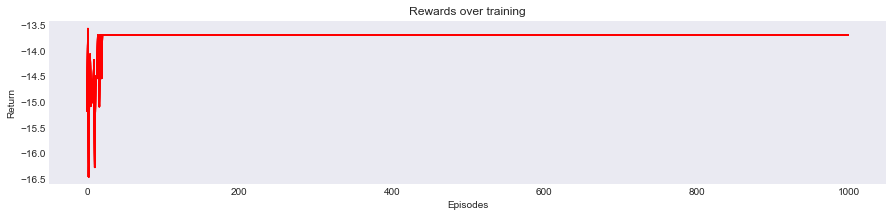

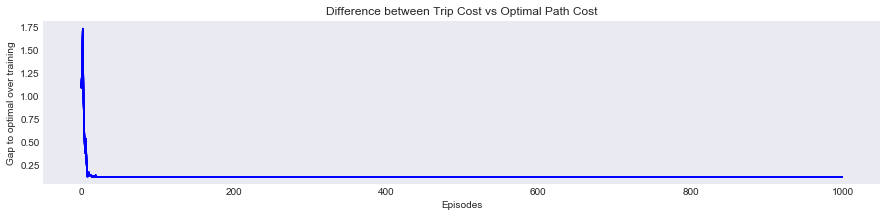

Policy: greedy ,Learning rate: 0.5 ,Discount_factor: 0.5 ,Descriptions: s11e1000bw1ww1dw1pgreedydf0.5lr0.5 ,Total Combinations: 362880 ,Best Ranking: 280.0 ,Worst Ranking: 280.0 ,Median Ranking: 280.0 ,Ranking: [280. 280. 280. 280. 280. 280. 280. 280. 280. 280. 280.]


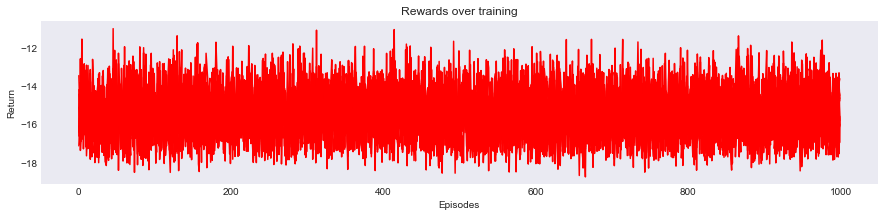

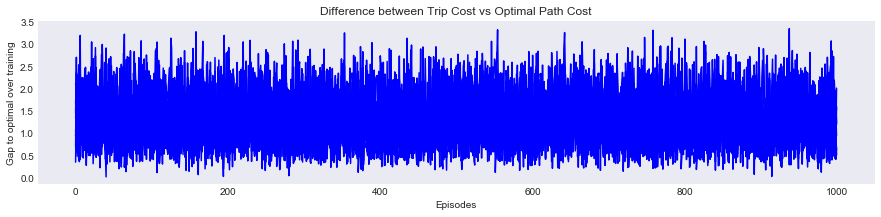

Policy: random ,Learning rate: 0.5 ,Discount_factor: 0.5 ,Descriptions: s11e1000bw1ww1dw1prandomdf0.5lr0.5 ,Total Combinations: 362880 ,Best Ranking: 15278.0 ,Worst Ranking: 320915.0 ,Median Ranking: 157195.0 ,Ranking: [166920. 235868.  94516.  15278.  26487. 250903. 157195. 312853.  37978.
  54185. 320915.]


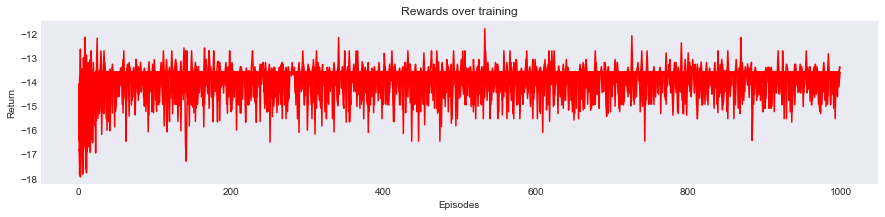

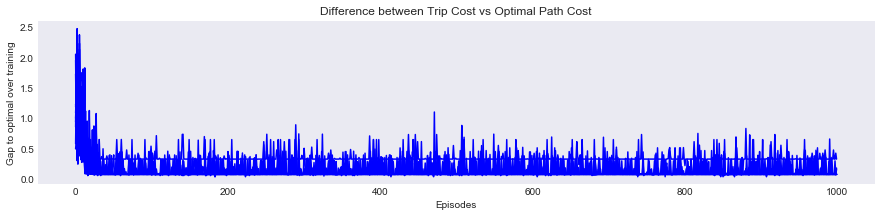

Policy: e-greedy ,Learning rate: 0.5 ,Discount_factor: 0.5 ,Descriptions: s11e1000bw1ww1dw1pe-greedydf0.5lr0.5 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 2991.0 ,Median Ranking: 98.0 ,Ranking: [ 401.   98. 2991.   98.   98.   98.   98.   98.  731.   98.   98.]


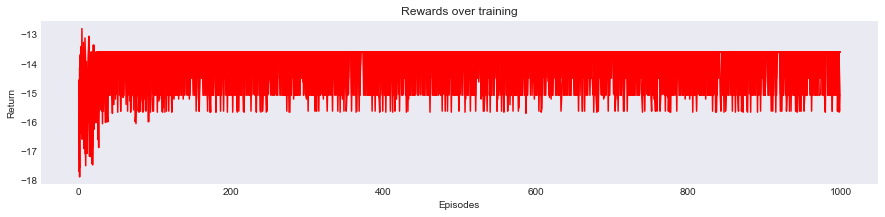

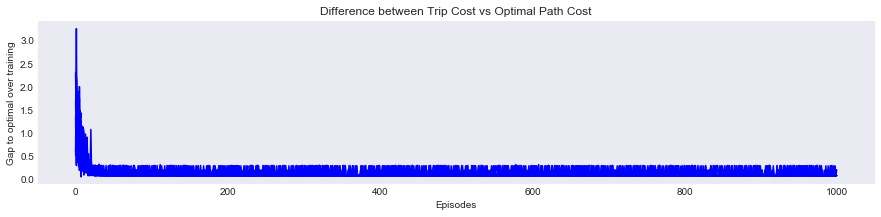

Policy: boltzman ,Learning rate: 0.5 ,Discount_factor: 0.5 ,Descriptions: s11e1000bw1ww1dw1pboltzmandf0.5lr0.5 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 1061.0 ,Median Ranking: 98.0 ,Ranking: [  98.   98.   98.   98.  925.  925. 1061.   98.   98.   98.   98.]


In [15]:
# parameters for grid searching
policies = ['greedy','random','e-greedy','boltzman']
learning_rate = 0.5
discount_factor = 0.5
samples = 11

for policy in policies: 
    dfResults = generate_output(all_gifts.iloc[0:10,:], results9_optimal_cost, results9, samples=samples, episodes=1000, \
                                show_plot=True, show_map=False, show_text=True, save_image=True, \
                               policy=policy, discount_factor=discount_factor, learning_rate=learning_rate)
        

## Hyperparmaeter - Learning Rate

Having determined that the e-greedy policy is the preferred policy, we evaluate various learning rates keeping all other values constant.

As the learning rate affects the speed with of learning we will limit number of episodes to 50 so that we can closely examine the speed of learning.

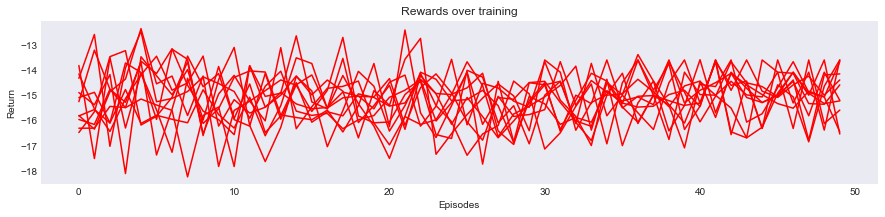

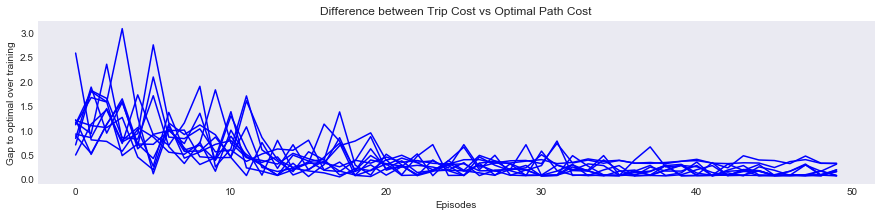

Policy: e-greedy ,Learning rate: 0.1 ,Discount_factor: 1 ,Descriptions: s11e50bw1ww1dw1pe-greedydf1lr0.1 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 4361.0 ,Median Ranking: 667.0 ,Ranking: [2991. 1015.  667.   98. 1138.   98.  130.  462. 3232.  520. 4361.]


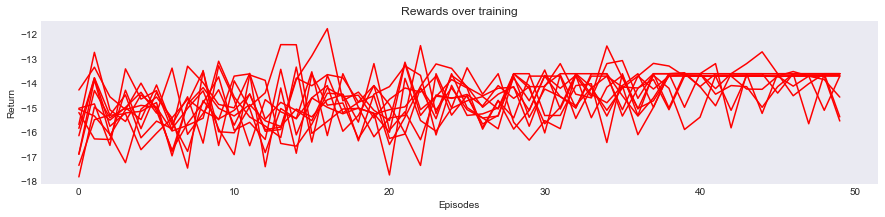

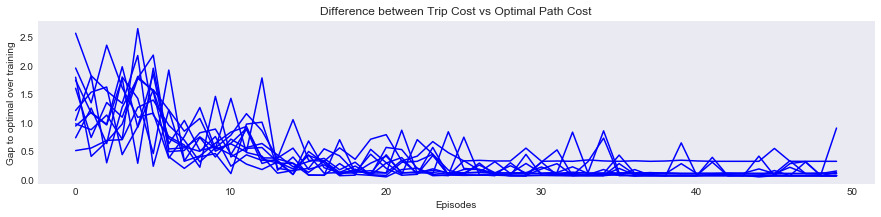

Policy: e-greedy ,Learning rate: 0.3 ,Discount_factor: 1 ,Descriptions: s11e50bw1ww1dw1pe-greedydf1lr0.3 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 86807.0 ,Median Ranking: 265.0 ,Ranking: [  265.   280.   784.    98.    98.    98.  2991. 86807.   280.    98.
    98.]


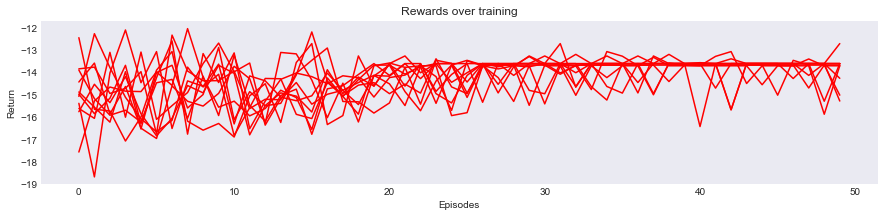

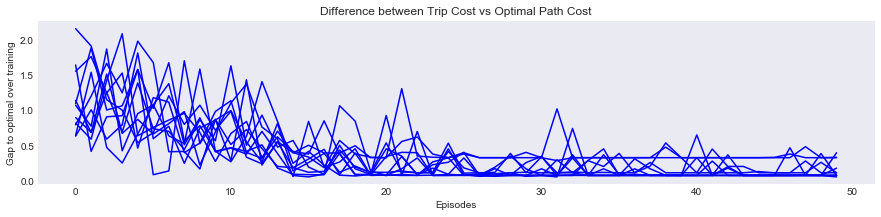

Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 1 ,Descriptions: s11e50bw1ww1dw1pe-greedydf1lr0.6 ,Total Combinations: 362880 ,Best Ranking: 55.0 ,Worst Ranking: 8844.0 ,Median Ranking: 280.0 ,Ranking: [ 719.   98.  280.   98. 2991.  280.   55.   98. 8844.   98. 3139.]


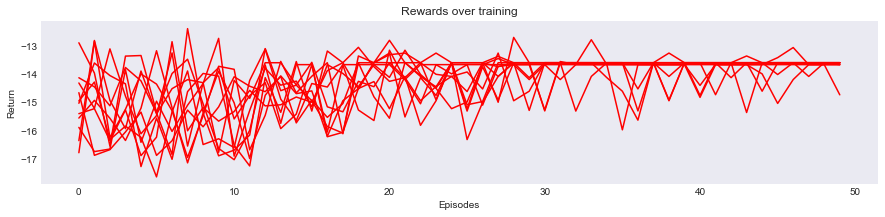

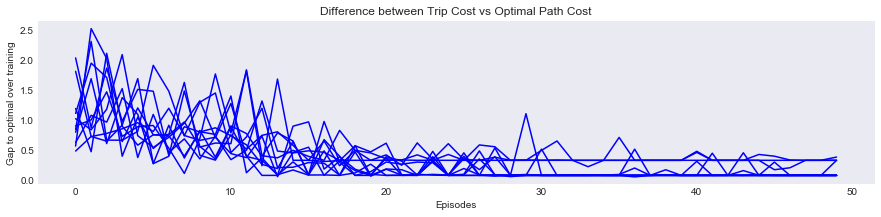

Policy: e-greedy ,Learning rate: 0.9 ,Discount_factor: 1 ,Descriptions: s11e50bw1ww1dw1pe-greedydf1lr0.9 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 5303.0 ,Median Ranking: 98.0 ,Ranking: [  98. 2991.   98.   98.   98. 2991.   98. 5303.   98.   98. 2991.]


In [16]:
policy = 'e-greedy'
learning_rates = [0.1, 0.3, 0.6, 0.9]
samples = 11
discount_factor=1

for learning_rate in learning_rates:
    dfResults = generate_output(all_gifts.iloc[0:10,:], results9_optimal_cost, results9, samples=samples, episodes=50, \
                                show_plot=True, show_map=False, show_text=True, save_image=True, \
                                policy=policy, discount_factor=discount_factor, learning_rate=learning_rate)

## Hyperparmeter - Discount Rate

Having determined best policy and learning rate, we step through the discount factor to evaluate its impact.

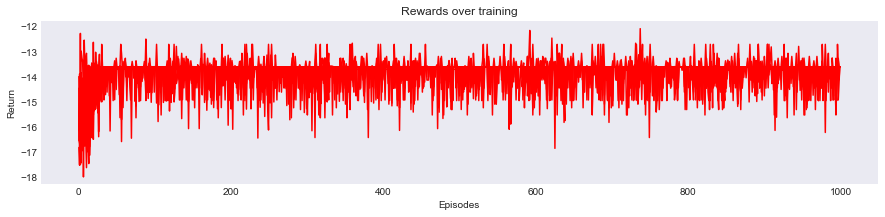

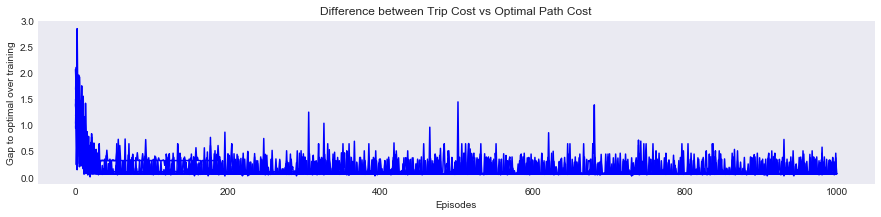

Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.1 ,Descriptions: s11e1000bw1ww1dw1pe-greedydf0.1lr0.6 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 98.0 ,Median Ranking: 98.0 ,Ranking: [98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.]


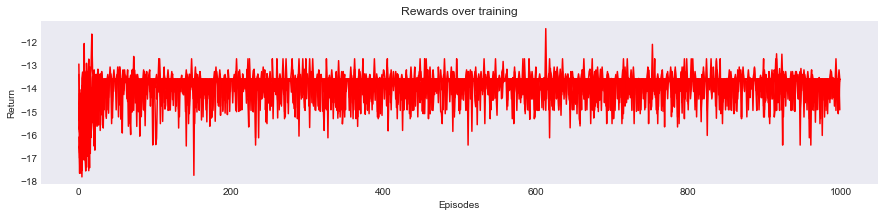

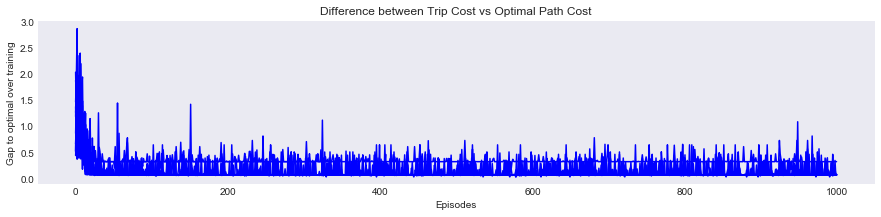

Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.3 ,Descriptions: s11e1000bw1ww1dw1pe-greedydf0.3lr0.6 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 2991.0 ,Median Ranking: 98.0 ,Ranking: [  98.   98.  131.   98.   98.   98.   98.   98.   98. 2991.   98.]


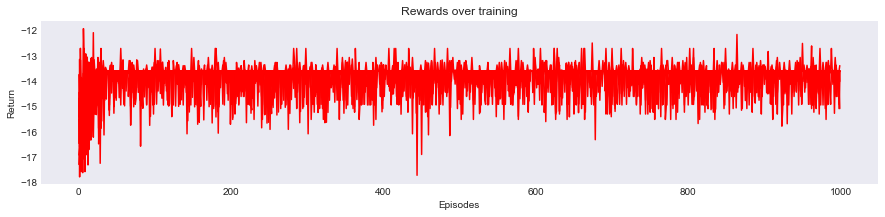

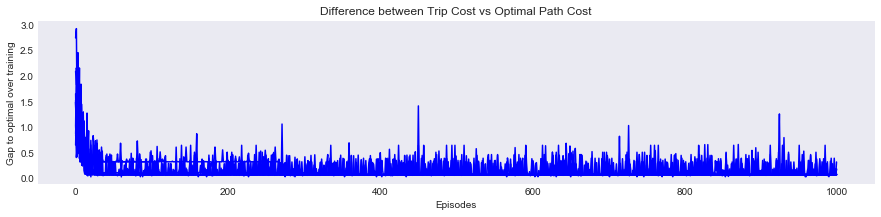

Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.6 ,Descriptions: s11e1000bw1ww1dw1pe-greedydf0.6lr0.6 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 4662.0 ,Median Ranking: 98.0 ,Ranking: [  98. 4662.  731.   98.   98.   98.   98.   98.   98.   98.  925.]


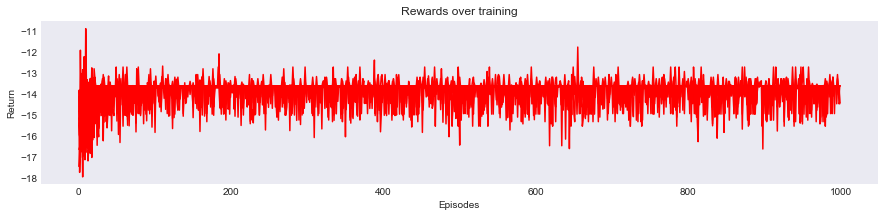

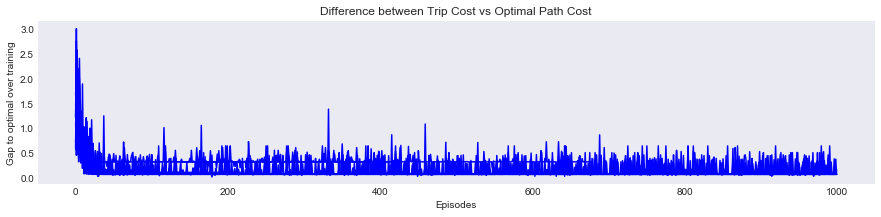

Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.9 ,Descriptions: s11e1000bw1ww1dw1pe-greedydf0.9lr0.6 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 520.0 ,Median Ranking: 98.0 ,Ranking: [ 98.  98.  98. 520. 264. 520.  98.  98.  98.  98.  98.]


In [17]:
policy = 'e-greedy'
learning_rate = 0.6
samples = 11
discount_factors = [0.1, 0.3, 0.6, 0.9]

for discount_factor in discount_factors:
        dfResults = generate_output(all_gifts.iloc[0:10,:], results9_optimal_cost, results9, samples=samples, episodes=1000, \
                                    show_plot=True, show_map=False, show_text=True, save_image=True, \
                                    policy=policy, discount_factor=discount_factor, learning_rate=learning_rate)


## Reward function evaluation

As a custom reward function is applied in this work, we evaluate the individual effect of the weighting factor for base, weight and distance-dependent rewards to illustrate how each impacts the path adopted by the agent

In [21]:
policy = 'e-greedy'
learning_rate = 0.6
discount_factor = 0.6
samples = 11

combinations = [[1,1,1],[1,1,0],[1,0,1], [0,1,1],[0,0,1],[0,1,0],[1,0,0]]
for ic, combination in enumerate(combinations):

        base_weight = combination[0]
        weight_weight = combination[1]
        distance_weight = combination[2]

        dfResults = generate_output(all_gifts.iloc[0:10,:], results9_optimal_cost, results9, samples=samples, episodes=1000, \
                                    show_plot=False, show_map=True, show_text=True, save_image=False, \
                                   policy=policy, discount_factor=discount_factor, base_weight=base_weight, \
                                    weight_weight=weight_weight, distance_weight=distance_weight, learning_rate=learning_rate)


Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.6 ,Descriptions: s11e1000bw1ww1dw1pe-greedydf0.6lr0.6 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 131.0 ,Median Ranking: 98.0 ,Ranking: [ 98.  98.  98.  98.  98.  98.  98.  98.  98. 112. 131.]


Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.6 ,Descriptions: s11e1000bw1ww1dw0pe-greedydf0.6lr0.6 ,Total Combinations: 362880 ,Best Ranking: 1352.0 ,Worst Ranking: 41964.0 ,Median Ranking: 12504.0 ,Ranking: [13739. 20650. 33442.  7177. 12504.  1352. 41964. 12068. 12449. 11639.
 20604.]


Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.6 ,Descriptions: s11e1000bw1ww0dw1pe-greedydf0.6lr0.6 ,Total Combinations: 362880 ,Best Ranking: 5926.0 ,Worst Ranking: 15404.0 ,Median Ranking: 10647.0 ,Ranking: [10647.  5926. 15404. 10647. 10647. 10647. 10647. 10647. 10647. 10647.
 10647.]


Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.6 ,Descriptions: s11e1000bw0ww1dw1pe-greedydf0.6lr0.6 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 4242.0 ,Median Ranking: 98.0 ,Ranking: [  98.   98.   98.   98.   98.   98.   98. 4242.   98.   98.   98.]


Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.6 ,Descriptions: s11e1000bw0ww0dw1pe-greedydf0.6lr0.6 ,Total Combinations: 362880 ,Best Ranking: 2539.0 ,Worst Ranking: 26614.0 ,Median Ranking: 10647.0 ,Ranking: [10647.  2539. 10647. 10647. 10647. 10647. 10647. 10647. 26614. 10647.
 10647.]


Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.6 ,Descriptions: s11e1000bw0ww1dw0pe-greedydf0.6lr0.6 ,Total Combinations: 362880 ,Best Ranking: 1132.0 ,Worst Ranking: 21113.0 ,Median Ranking: 12503.0 ,Ranking: [21113.  4757. 12503.  1132. 12503. 12503. 12503. 12503. 12503. 12503.
 12503.]


Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.6 ,Descriptions: s11e1000bw1ww0dw0pe-greedydf0.6lr0.6 ,Total Combinations: 362880 ,Best Ranking: 3239.0 ,Worst Ranking: 356824.0 ,Median Ranking: 94385.0 ,Ranking: [113467. 309934.  94385. 279644.   3239.   6046. 356824.  90883.  71197.
   5623. 329503.]


## Reward Function Parameter Exploration

Having shown that varying the reward function has a big impact on the route taken we grid search various values of the three reward fn parameters to see if we can optimise the returns

In [22]:
show_plot = False
show_map = False

policies = ['e-greedy']
learning_rate = 0.6
samples = 11
discount_factor = 0.6

base_weights = [1,2,3]
weight_weights = [0.1, 1, 2]
distance_weights = [0.1, 1, 2]

# dictionaries to store the return & diff2opt dataframes so they can be plotted and averaged for final result
dfAllResults=pd.DataFrame(columns=['Description','Sample','Rank','Return','Diff2Opt'])

for policy in policies: 
        for base_weight in base_weights:
            for weight_weight in weight_weights:
                for distance_weight in distance_weights:
            
                    dfResults = generate_output(all_gifts.iloc[0:10,:], results9_optimal_cost, results9, samples=samples, episodes=1000, \
                                                show_plot=False, show_map=False, show_text=False, save_image=False, \
                                               base_weight=base_weight, weight_weight=weight_weight, distance_weight=distance_weight, \
                                               policy=policy, discount_factor=discount_factor, learning_rate=learning_rate)
                
                    dfAllResults=dfAllResults.append(dfResults)

# Print out results to see which combinations work best
print(dfAllResults.groupby(['Description']).agg({'Rank':np.mean, 'Diff2Opt':np.mean}).sort_values(by='Diff2Opt'))

                                                  Rank  Diff2Opt
Description                                                     
s11e1000bw2ww2dw2pe-greedydf0.6lr0.6         98.000000  0.083196
s11e1000bw1ww1dw1pe-greedydf0.6lr0.6         98.000000  0.083196
s11e1000bw2ww1dw2pe-greedydf0.6lr0.6        128.181818  0.089213
s11e1000bw3ww1dw1pe-greedydf0.6lr0.6        176.181818  0.094642
s11e1000bw1ww2dw2pe-greedydf0.6lr0.6        793.545455  0.110846
s11e1000bw3ww1dw2pe-greedydf0.6lr0.6        287.000000  0.112202
s11e1000bw2ww1dw1pe-greedydf0.6lr0.6        467.818182  0.112664
s11e1000bw3ww2dw2pe-greedydf0.6lr0.6       1483.727273  0.120850
s11e1000bw1ww1dw2pe-greedydf0.6lr0.6       1399.272727  0.146340
s11e1000bw2ww0.1dw0.1pe-greedydf0.6lr0.6   1411.909091  0.212990
s11e1000bw1ww0.1dw0.1pe-greedydf0.6lr0.6   2103.272727  0.231864
s11e1000bw3ww0.1dw0.1pe-greedydf0.6lr0.6  15431.909091  0.381689
s11e1000bw2ww0.1dw2pe-greedydf0.6lr0.6    10026.363636  0.390894
s11e1000bw3ww2dw0.1pe-gre

## Best Model

We now have the best parameters for our model and as such we can finally run the best model

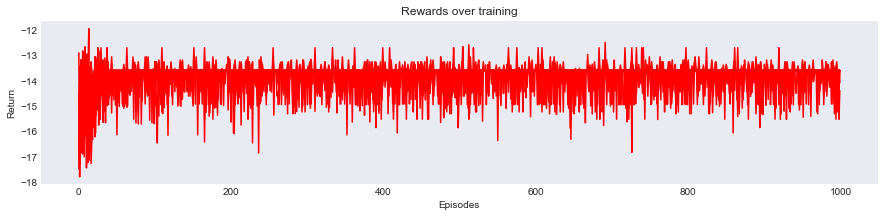

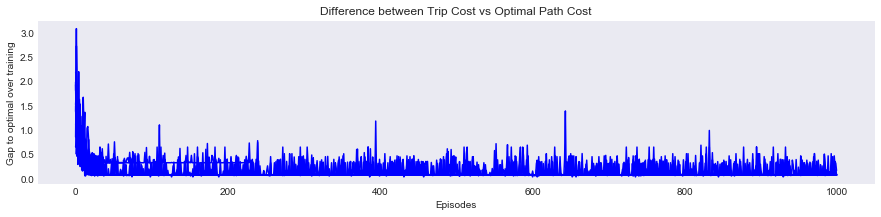

Policy: e-greedy ,Learning rate: 0.6 ,Discount_factor: 0.6 ,Descriptions: s11e1000bw1ww1dw1pe-greedydf0.6lr0.6 ,Total Combinations: 362880 ,Best Ranking: 98.0 ,Worst Ranking: 520.0 ,Median Ranking: 98.0 ,Ranking: [ 98.  98. 520.  98.  98.  98.  98.  98.  98. 112.  98.]


In [23]:
# Variables used for best policy
policy = 'e-greedy'
learning_rate = 0.6
samples = 11
discount_factor = 0.6
base_weight = 1
weight_weight = 1
distance_weight = 1

dfResults = generate_output(all_gifts.iloc[0:10,:], results9_optimal_cost, results9, \
                            samples=samples, episodes=1000, \
                            show_plot=True, show_map=True, show_text=True, save_image=True, \
                           base_weight=base_weight, weight_weight=weight_weight, distance_weight=distance_weight, \
                           policy=policy, discount_factor=discount_factor, learning_rate=learning_rate)


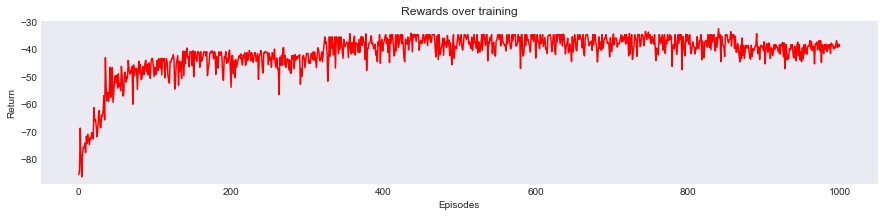

In [24]:
policy = 'e-greedy'
learning_rate = 0.6
samples = 11
discount_factor = 0.6
base_weight = 1
weight_weight = 1
distance_weight = 1

dfResults = generate_output(all_gifts.iloc[0:50,:], [], [], \
                            samples=1, episodes=1000, \
                            show_plot=True, show_map=True, show_text=True, save_image=True, \
                           base_weight=base_weight, weight_weight=weight_weight, distance_weight=distance_weight, \
                           policy=policy, discount_factor=discount_factor, learning_rate=learning_rate)

## Alternative Algorithm (SARSA)

In [28]:
class SARSAgent(Agent):
    def __init__(self, states_size, actions_size, exploration="e-greedy", epsilon = 1.0, epsilon_min = 0.01, epsilon_decay = 0.999, gamma = 0.95, lr = 0.8):
        self.states_size = states_size
        self.actions_size = actions_size
        self.exploration="e-greedy",
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.lr = lr
        self.Q = self.build_model(states_size, actions_size)
        
    def build_model(self, states_size, actions_size):
        Q = np.zeros([states_size, actions_size])
        return Q
    
    def train(self, s, a, r, s_next):
        a_next = self.act(s_next)
        self.Q[s,a] = self.Q[s,a] + self.lr*(r+self.gamma*self.Q[s_next, a_next] - self.Q[s,a])
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, s):
        q = self.Q[s,:]
        
        if np.random.rand() > self.epsilon:
            a = np.argmax(q)
        else:
            a = np.random.randint(self.actions_size)
            
        return a

In [29]:
class DeliverySARSAgent(SARSAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reset_memory()
    
    def act(self, s):
        # Getting Q vectors for a specific state
        q = np.copy(self.Q[s,:])
        
        # Avoid visited states
        q[self.states_memory] = -np.inf
        
        if np.random.rand() > self.epsilon:
            a = np.argmax(q)
        else:
            a = np.random.choice([x for x in range(self.actions_size) if x not in self.states_memory])
        
        return a
    
    def remember_state(self,s):
        self.states_memory.append(s)
    
    def reset_memory(self):
        self.states_memory = []

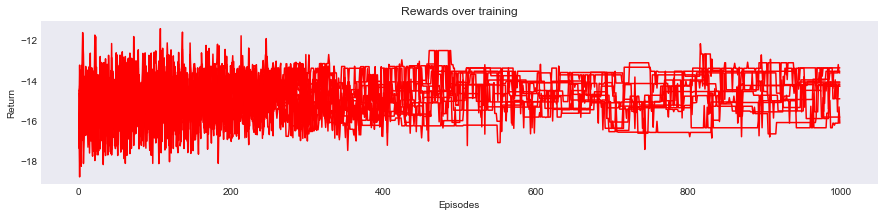

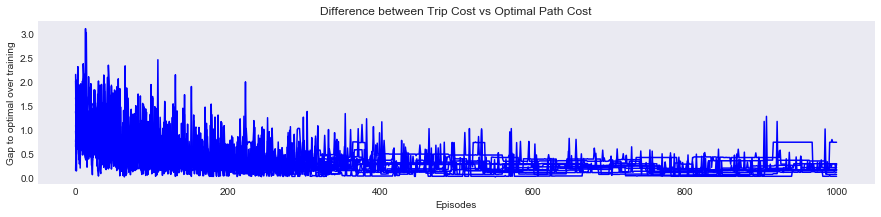

In [34]:
# Variables used for best policy
policy = 'e-greedy'
learning_rate = 0.6
samples = 11
discount_factor = 0.6
base_weight = 1
weight_weight = 1
distance_weight = 1

dfResults = generate_soutput(all_gifts.iloc[0:10,:], results9_optimal_cost, results9, \
                            samples=samples, episodes=1000, \
                            show_plot=True, show_map=True, show_text=False, save_image=True, \
                           base_weight=base_weight, weight_weight=weight_weight, distance_weight=distance_weight, \
                           policy=policy, discount_factor=discount_factor, learning_rate=learning_rate)


## Multi Agent Scenario

In [35]:
# runs n episodes, if  an optimal cost is passed then difference between calculated route
# and optimal path is calculated for analysis
def marl_run_n_episodes(env, agent1, agent2, optimal_cost=[], name="training.gif", n_episodes=1000, render_each=10, fps=10):
    # Store the rewards
    diffs = []
    rewards = []
    
    # Experience replay - used to provide feedback; our examples do not need it
    #for i in tqdm_notebook(range(n_episodes)):
    
    # loop over the episodes
    for i in range(n_episodes): 
        
        # Run the episdoe
        env, agent1, agent2, episode_reward = marl_run_episode(env, agent1, agent2, verbose=0)
        
        rewards.append(episode_reward)
        
         
    return env, agent1, agent2, rewards, diffs

# combines environment and agent classes creating the flow of S->A->R
# runs a single episode; terminating when no more gifts to be delivered
# individual rewards accumalte to a final return
def marl_run_episode(env, agent1, agent2, verbose = 1):
    
    s=env.reset()
    agent1.reset_memory()
    agent2.reset_memory()
    
    max_step = len(env.gifts)
    
    episode_reward = 0
    
    i = 0
    while i<(max_step/2)-1:
        for iagent in range(2):

            if iagent == 1:
                active_agent = agent1
                passive_agent = agent2
            else:
                active_agent = agent2
                passive_agent = agent1            

            # Remember the states - both agents need to remember the states
            active_agent.remember_state(s)
            passive_agent.remember_state(s)
            
            # Choose an action - only active one chooses
            a = active_agent.act(s)

            # Take the action and get the reward
            s_next, r, done = env.step(a, iagent)

            # Update knowledge in Q-Table
            active_agent.train(s,a,r,s_next)
            passive_agent.anti_train(s,a,r,s_next)

            # Update cache on current state and reward
            episode_reward += r
            s = s_next

        # Terminate episode when done
        i += 1
        if done:
            break

    return env, agent1, agent2, episode_reward

In [38]:
class MarlDeliveryQAgent(DeliveryQAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def anti_train(self, s, a, r, s_next):    
        self.Q[s,a] = self.Q[s,a] - self.lr*(r+self.gamma*np.max(self.Q[s_next,a]) - self.Q[s,a])

In [39]:
# DeliveryEnvironment: base class for defining environment
# methods:
# __init__: initialises env parameters, generates the states (gifts)
# _generate_stops: stores longitude and latitude for each stop
# _generate_distance_matrix: creates a matrix holding distances from gift to gift
# render: creates the map and draws lines between gifts
# reset: clears stops and initialises the start point (Lapland)
# step: adds new step and generates reward for transitioning from step to step
# _get_state: gets present state
# _get_xy: retrieves longitude & latitude
# _get_reward: calculates the reward
class MarlDeliveryEnvironment(object):
    def __init__(self, gifts = [[0,90,135,0],[0,90,135,0]], base=1, alpha=1, beta=1, debug=0, **kwargs):
        
        # Initialization        
        self.gifts = gifts
        self.basemap = create_map(self.gifts)
        self.base = base
        self.alpha = alpha
        self.beta = beta
        self.n_stops = len(gifts)
        self.observation_space = self.n_stops
        self.action_space = self.n_stops
        self.debug = debug
        
        self.stops1 = []
        self.stops2 = []
        
        # Generate stops
        self._generate_stops()
        self._generate_distance_matrix()                
        
        # Initialize first point
        self.reset()
           
    def _generate_stops(self):             
        self.n_stops = len(self.gifts)
        self.x = self.gifts.iloc[:,1]
        self.y = self.gifts.iloc[:,2]
        
    def _generate_distance_matrix(self):
        # Generate actual Q Values corresponding to gc distance between 2 points
        self.q_stops = cdist(self.gifts.iloc[:,1:3], self.gifts.iloc[:,1:3])        
            
    def render(self):
        map = create_map(self.gifts)
        if len(self.stops2) <= 1:
            pass
        else:
            for i in range(0, len(self.stops1)-1):
                p1=[self.x[self.stops1[i]],self.y[self.stops1[i]]]
                p2=[self.x[self.stops1[i+1]], self.y[self.stops1[i+1]]]
                folium.PolyLine(locations=[p1, p2], color='red').add_to(map)
                    
            for i in range(0, len(self.stops2)-1):
                p1=[self.x[self.stops2[i]],self.y[self.stops2[i]]]
                p2=[self.x[self.stops2[i+1]], self.y[self.stops2[i+1]]]
                folium.PolyLine(locations=[p1, p2], color='blue').add_to(map)
                    
        display(map)
                
    def reset(self):
        
        # Stops placeholder
        self.stops1 = []
        self.stops2 = []
        
        #Randomly choose first stop ... remember need to travel here from North Pole first
        first_stop = 0
        self.stops1.append(first_stop)
        self.stops2.append(first_stop)
        
        return first_stop
    
    def step(self,destination, agent):
        
        # Get current state
        state = self._get_state(agent)
        new_state = destination
        
        # Get reward for move
        reward = self._get_reward(state, new_state)
        
        # Append new_state to stops
        if agent == 1:
            self.stops1.append(destination)        
        else:
            self.stops2.append(destination)        
            
        done = len(self.stops2) == self.n_stops #All delivered
        
        return new_state, reward, done

    def _get_state(self, agent):
        if agent == 1:
            return self.stops1[-1] # return last item in list
        else:
            return self.stops2[-1] # return last item in list
    
    def _get_reward(self, state, new_state):        
        base_reward = 1
        #print("Weight: " + str(self.gifts.iloc[new_state,3]))
        weight_reward = (self.alpha * math.log(self.gifts.iloc[new_state,3]))
        #print("Distance: "+str(self.q_stops[state, new_state]))
        distance_reward = (self.beta * math.log(self.q_stops[state, new_state]))
        if self.debug == 1:
            print("Reward:", (1 + weight_reward - distance_reward))
        return self.base + weight_reward - distance_reward

In [40]:
base_weight = 1
weight_weight = 1
distance_weight = 1

discount_factor = 0.1
learning_rate = 0.9


gifts = all_gifts.iloc[0:20,:]

env = MarlDeliveryEnvironment(gifts=gifts, \
                          base=base_weight, \
                          alpha=weight_weight, \
                          beta=distance_weight)
# initialise the agent
agent1 = MarlDeliveryQAgent(env.observation_space, env.action_space, \
                       exploration=policy, \
                       gamma=discount_factor, \
                       lr=learning_rate)

agent2 = MarlDeliveryQAgent(env.observation_space, env.action_space, \
                       exploration=policy, \
                       gamma=discount_factor, \
                       lr=learning_rate)


# run the episodes
env, agent1, agent2, rewards, diff2opt = marl_run_n_episodes(env, agent1, agent2, results9, n_episodes=5000); 

env.render()